<a href="https://colab.research.google.com/github/Yugi-Seong/AudioDataAugumentation-/blob/main/EnvironmentalCorruption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environmental Corruption Tutorial

1. clean 음성 신호 + 잡음 신호 첨가
2. 장점 : 다른 노이즈 및 잔향(메아리)을 사용함으로 다양한 방식으로 인위적으로 신호를 오염시킬 수 있음   
=> 테스트 세트에서 네트워크를 더 잘 일반화 가능케 함  


3. 종류   
a. Noise Mixing  
b. Reverberation  
c. Environmental Corruption Lobe (a + b)

4. $y[n] = x[n] * h[n] + n[n]$

  x[n] : 깨끗한 신호  
  h[n] : 잔향 신호 (b.reverberation)  
  n[n] : 잡음 (a.noise mixing)





In [ ]:
%%capture

# speechbrain : pytorch 를 기반으로하는 종합적인 음성처리 툴킷 
!pip install speechbrain

# noise mixing 
!wget https://www.dropbox.com/s/vwv8xdr7l3b2tta/noise_sig.csv
!wget https://www.dropbox.com/s/aleer424jumcs08/noise2.wav
!wget https://www.dropbox.com/s/eoxxi2ezr8owk8a/noise3.wav
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

# reverberation 
!wget https://www.dropbox.com/s/pjnub2s5hql2vxs/rir1.wav
!wget https://www.dropbox.com/s/nyno6bqbmiy2rv8/rirs.csv

clean speech data 불러오기  

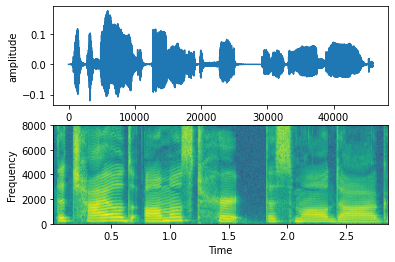

In [ ]:
# 시각화 라이브러리 
import matplotlib.pyplot as plt

# 데이터 로딩 및 데이터 전처리 
# speechbrain 공식문서 : https://speechbrain.readthedocs.io/en/latest/index.html
from speechbrain.dataio.dataio import read_audio

# python 에 대한 대화형 인터페이스 제공 
# https://ipython.org/ipython-doc/3/api/generated/IPython.display.html?highlight=audio#IPython.display.Audio
from IPython.display import Audio

# https://speechbrain.readthedocs.io/en/latest/API/speechbrain.dataio.dataio.html#speechbrain.dataio.dataio.read_audio 
clean = read_audio('spk1_snt1.wav').squeeze()
# print(clean)

# Plots
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html?highlight=subplot#matplotlib.pyplot.subplot
# subplot(nrows, ncols, plot_number) => nrows=2 ncols=1 plot_number=1
# => 2행 x 1열의 개념적 그리드에서 상단 플롯(즉, 첫 번째)을 나타내는 그림의 하위 축을 생성
plt.subplot(211)
plt.plot(clean)
plt.xlabel('Time')
plt.ylabel('amplitude')

plt.subplot(212)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html?highlight=specgram#matplotlib.pyplot.specgram
plt.specgram(clean,Fs=16000)
# => clean data 의 spectrogram plotting 
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(clean, rate=16000) 
# rate : The sampling rate of the raw data
# sample rate : 소리 (아날로그 신호) -> 숫자 (디지털 신호)  
# 16khz : 1초당 16000 번의 samples 를 기록

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html

* 파형 : 아날로그 신호
* 샘플링한 점 부분 : 디지털신호 

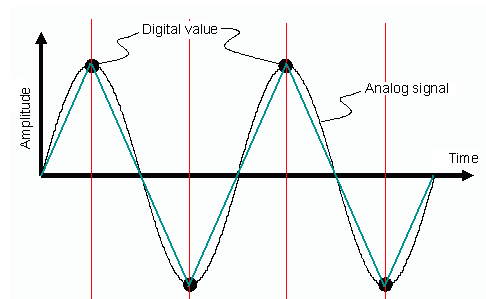

## 1. Additive Noise

1. (speechbrain.processing.speech_augmentation.AddNoise)로 오염시킬 수 있는 클래스를 설계함  
2. 이 클래스로 노이즈 신호 목록을 항목화하는 csv 파일을 입력받음  
3. 호출되면 AddNoise는 이 노이즈 컬렉션에서 샘플링함   
4. 선택한 노이즈를 임의의 SNR(Signal-to-Nose Ratio)로 깨끗한 신호에 추가함

In [ ]:
import pandas as pd 

df = pd.read_csv('noise_sig.csv')
df

,ID,duration,wav,wav_format,wav_opts
0,noise2,5.0,noise2.wav,wav,NaN
1,noise3,1.0,noise3.wav,wav,NaN


In [ ]:
sound_file ='noise2.wav'
Audio(sound_file)

Text(0, 0.5, 'amplitude')

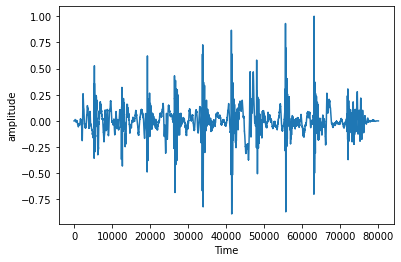

In [ ]:
sound_file2_1 = read_audio('noise2.wav').squeeze()
plt.plot(sound_file2_1)
plt.xlabel('Time')
plt.ylabel('amplitude')

In [ ]:
sound_file3 ='noise3.wav'
Audio(sound_file3)

Text(0, 0.5, 'amplitude')

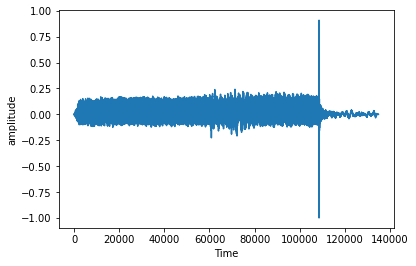

In [ ]:
sound_file3_1 = read_audio('noise3.wav').squeeze()
plt.plot(sound_file3_1)
plt.xlabel('Time')
plt.ylabel('amplitude')

tensor([[ 0.0050,  0.0050,  0.0049,  ..., -0.0141, -0.0140, -0.0142]])


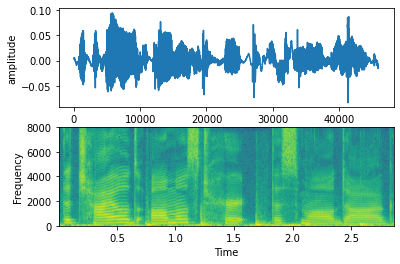

In [ ]:
import torch

# 음성신호를 노이즈로 오염시키기 위해 필요한 모듈 import 
# https://speechbrain.readthedocs.io/en/latest/API/speechbrain.processing.speech_augmentation.html?highlight=speechbrain.processing#speechbrain.processing.speech_augmentation.AddNoise
from speechbrain.processing.speech_augmentation import AddNoise

# 1.(speechbrain.processing.speech_augmentation.AddNoise)로 오염시킬 수 있는 클래스생성
# 2. 이 클래스는 노이즈 신호 csv 파일을 입력받음.
# 3. 호출되면 AddNoise는 이 노이즈 컬렉션에서 샘플링함   
noisifier = AddNoise('noise_sig.csv', snr_low=-10, snr_high=10) 
lengths = torch.ones(1) # 단일 차원 배치 모양 텐서 
# 4. 선택한 노이즈를 임의의 SNR(Signal-to-Nose Ratio)로 깨끗한 신호에 추가.
noisy = noisifier(clean.unsqueeze(0), lengths)
print(noisy)


# snr_low  : (int)혼합 비율의 데시벨 하한값
# snr_high  : (int)혼합 비율의 데시벨 상한값
# 데시벨(deci bell) : 소리의 측정단위 ; int -> 10^int 배 
# snr_high, snr_low 를 이용해서 노이즈의 양을 조절 가능!

# Plots
# 시간 - 진폭 파형으로 표현 
plt.subplot(211)
plt.plot(noisy.squeeze())
plt.xlabel('Time')
plt.ylabel('amplitude')

# 시간 - 주파수 스펙토그램으로 표현 
plt.subplot(212)
plt.specgram(noisy.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noisy.squeeze(0), rate=16000)

clean data  vs  noise를 첨가한 data 

Text(0, 0.5, 'amplitude')

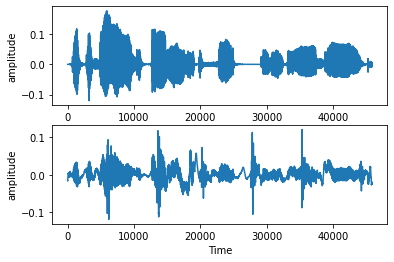

In [ ]:
# clean data 파형 
plt.subplot(211)
plt.plot(clean.squeeze())
plt.ylabel('amplitude')

# noise data 파형
plt.subplot(212)
plt.plot(noisy.squeeze())
plt.xlabel('Time')
plt.ylabel('amplitude')

Text(0, 0.5, 'Frequency')

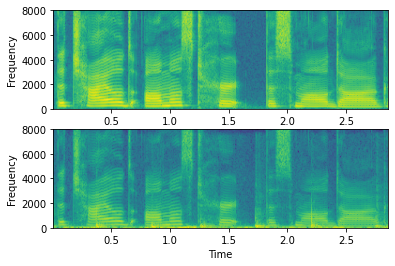

In [ ]:
# clean data spectogram
plt.subplot(211)
plt.specgram(clean,Fs=16000)
plt.ylabel('Frequency')

# noise data 스펙토그램으로 표현 
plt.subplot(212)
plt.specgram(noisy.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [ ]:
Audio(clean, rate=16000) 

In [ ]:
Audio(noisy.squeeze(0), rate=16000)

1. SNR의 샘플링 범위를 정의하는 snr_low 및 snr_high 매개변수로 노이즈의 양 조정가능 
2. 길이 벡터는 길이가 다른 신호의 병렬 배치를 처리할 수 있기 때문에 필요함. 길이 벡터는 배치를 구성하는 각 문장에 대한 상대 길이를 포함.
(예: 두 가지 예의 경우 lenght=[0.8 1.0]을 가질 수 있음. 
여기서 1.0은 배치에서 가장 긴 문장의 길이)

# 2. Reverberation
=> 다중 경로 전파 :  **잔향**  (메아리) 
잔향은 시간 및 주파수 영역에서 신호를 "부드럽게" 만드는 복잡한 잡음.
 
방에 말할 때 우리의 음성은 벽, 바닥, 천장 및 음향 환경 내의 물체에 의해 **여러 번 반사**됨.   
결과적으로 원거리 마이크에 의해 녹음된 최종 신호에는 **원래 신호의 지연된 복제본이 여러 개 포함** 됨.   
이러한 모든 복제본은 **서로 간섭하고 음성 신호의 명료도에 상당한 영향을 미침**.

주어진 방 내에서 소스와 수신기 사이의 잔향은 임펄스 응답으로 모델링 됨.



In [ ]:
sound_file4 ='rir1.wav'
Audio(sound_file4)

Text(0, 0.5, 'amplitude')

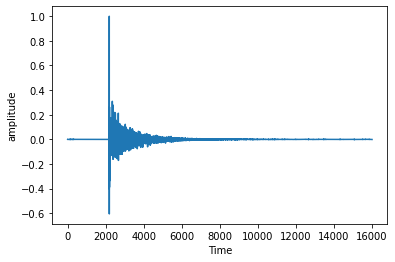

In [ ]:
sound_file4_1 = read_audio('rir1.wav').squeeze()
plt.plot(sound_file4_1)
plt.xlabel('Time')
plt.ylabel('amplitude')

(-0.5, 0.5)

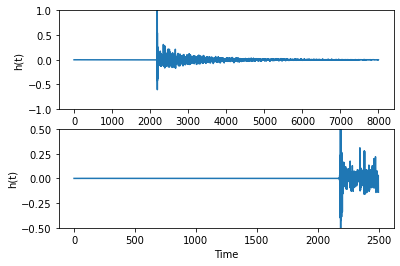

In [ ]:
rir = read_audio('rir1.wav')

# Impulse response : h(t)
# t = 0 일때, 입력이 들어간 순간 

plt.subplot(211)
plt.plot(rir[0:8000])
plt.xlabel('Time')
plt.ylabel('h(t)')
plt.ylim(-1,1)


# Zoom on early reflections
plt.subplot(212)
plt.plot(rir[0:2500])
plt.xlabel('Time')
plt.ylabel('h(t)')
plt.ylim(-0.5,0.5)

임펄스 응답은 소리가 소스에서 수신기로 이동할 때 겪는 변화를 보여줌.  
임펄스 응답의 각 피크는 수신기에 도달하는 복제본에 해당.   
첫 번째 피크는 직접 경로이며, 그런 다음 벽, 천장, 바닥에서 1차 반사를 볼 수 있음(두번째 그림 참조)

전반적으로 임펄스 응답은 기하급수적인 감쇠를 따름. 이 감쇠는 잔향 시간이 낮은 건조한 방에서 더 빠르고, 크고 비어 있는 환경에서는 더 느림.

잔향은 깨끗한 신호와 임펄스 응답 사이에 컨볼루션을 수행하여 추가됨. 
->x[n]∗h[n]  

In [ ]:
import pandas as pd

df2 = pd.read_csv('rirs.csv')
df2

,ID,duration,wav,wav_format,wav_opts
0,rir1,1.0,rir1.wav,wav,NaN


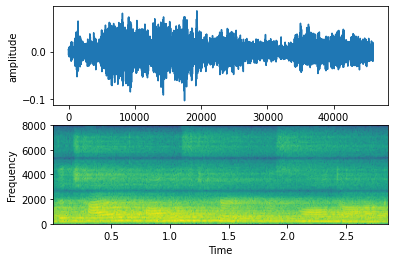

In [ ]:
# SpeechBrain에서 이 작업은 speechbrain.processing.speech_augmentation.AddReverb에 의해 수행됨.
# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.processing.speech_augmentation.html?highlight=addnoise%20#speechbrain.processing.speech_augmentation.AddNoise
from speechbrain.processing.speech_augmentation import AddReverb

# rir_scale_factor ( float ) – 주어진 임펄스 응답을 압축하거나 확장한다. 
# 잔향의 양은 rir_scale_factor 매개변수에 의해 제어 
# 0 < scale_factor < 1이면 임펄스 응답이 압축되고(더 적은 잔향), scale_factor > 1이면 확장됨(더 많은 잔향).
# 호출되면 AddRev는 주어진 csv 파일에서 임펄스 응답을 샘플링함.
reverb = AddReverb('rirs.csv', rir_scale_factor=6) 
# rir_scale_factor 을 변화시키며 확인 가능 
reverbed = reverb(clean, torch.ones(1))

# Plots
plt.subplot(211)
plt.plot(reverbed.squeeze())
plt.xlabel('Time')
plt.ylabel('amplitude')


plt.subplot(212)
plt.specgram(reverbed.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(reverbed.squeeze(0), rate=16000)


In [ ]:
Audio(clean, rate=16000) 

## 3. Environmental Corruption Lobe (1 + 2)

소음(noise) + 잔향(reverberation) 특정 확률로 결합되어 활성화. 

클래스 내에서 손상 작업 순서 = 먼저 잔향을 도입 한 후, 노이즈가 추가.  
y[n]=x[n]∗h[n]+n[n]  
이 클래스는 임펄스 응답 및 open-rir이라는 노이즈 시퀀스의 오픈 소스 데이터 세트를 자동으로 다운로드하고 샘플링을 수행.  

./rirs_noises.zip exists. Skipping download


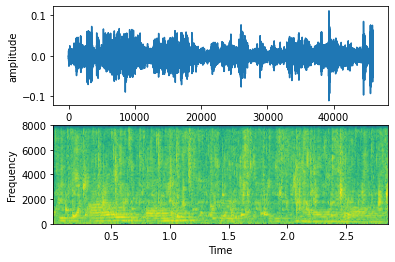

In [ ]:
# SpeechBrain에는 Speechbrain.lobes.augment.EnvCorrupt에 TimeDomainSpecAugment라는 클래스이용.
# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.lobes.augment.html#speechbrain.lobes.augment.EnvCorrupt
from speechbrain.lobes.augment import EnvCorrupt

# 이 클래스는 임펄스 응답 및 open-rir이라는 노이즈 시퀀스의 오픈 소스 데이터 세트를 자동으로 다운로드하고 샘플링을 수행.  
# open rir 다운로드 및 백업에 몇 분 정도 소요됨 
corrupter = EnvCorrupt(openrir_folder='.') 
noise_rev = corrupter(clean.unsqueeze(0), torch.ones(1))
#=> 왜곡된 파형을 반환 

# Plots
plt.subplot(211)
plt.plot(noise_rev.squeeze())
plt.xlabel('Time')
plt.ylabel('amplitude')

plt.subplot(212)
plt.specgram(noise_rev.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noise_rev.squeeze(0), rate=16000)

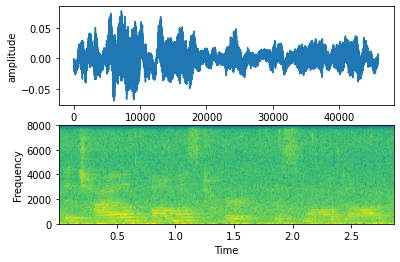

In [ ]:
# 함수를 다시 호출하여 신호가 다른 방식으로 오염되게 함
## 즉석 오염을 구현하고, 서로 다른 입력에 서로 다른 데이터를 생성해 낼 수 있음 
noise_rev = corrupter(clean.unsqueeze(0), torch.ones(1))

# Plots
plt.subplot(211)
plt.plot(noise_rev.squeeze())
plt.xlabel('Time')
plt.ylabel('amplitude')

plt.subplot(212)
plt.specgram(noise_rev.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noise_rev.squeeze(0), rate=16000)

이 외에도 음성 증강을 수행하는 데 사용할 수 있는 다른 유형의 왜곡이 존재함 
(예: 속도 변경, 시간 드롭아웃, 주파수 드롭아웃, 클리핑)   
=> speech augmentation tutorial 에 설명되어있음 

## References
[1] M. Ravanelli, P. Svaizer, M. Omologo, "Realistic Multi-Microphone Data Simulation for Distant Speech Recognition",  in Proceedings of Interspeech 2016 [ArXiv](https://arxiv.org/abs/1711.09470)

[2] M. Ravanelli, M. Omologo, "Contaminated speech training methods for robust DNN-HMM distant speech recognition", in Proceedings of  INTERSPEECH 2015. [ArXiv](https://arxiv.org/abs/1710.03538)

[3] M. Ravanelli, M. Omologo, "On the selection of the impulse responses for distant-speech recognition based on contaminated speech training", in Proceedings of  INTERSPEECH 2014. [ArXiv](https://isca-speech.org/archive/archive_papers/interspeech_2014/i14_1028.pdf)

[4] M. Ravanelli, A. Sosi, P. Svaizer, M.Omologo, "Impulse response estimation for robust speech recognition in a reverberant environment",   in Proceeding of the European Signal Processing Conference, EUSIPCO 2012. [ArXiv](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2012/Conference/papers/1569588145.pdf)



# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```